# Paramètres à adapter

Les modèles ci-dessous prennent en entrées les images redimensionnées et classées en sous-dossiers par le notebook resize_sort_images.ipynb.

Il faut adapter les chemins ci-dessous pour qu'ils renvoient vers les dossiers créés par resize_sort_images.ipynb.

In [ ]:
train_set_path = "/Users/antoine/Pictures/DataScientest_Rakuten/sorted/train_dataset/"
val_set_path = "/Users/antoine/Pictures/DataScientest_Rakuten/sorted/val_dataset/"

# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
import tensorflow_addons as tfa # deprecated (see warning below), but cannot use F1Score from tensorflow.keras.metrics 
# because it is only available in newest versions of tensorflow, which are not usable as for now (may 2024) on Mac computers. 
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from plot_keras_history import show_history, plot_history
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom

from sklearn.metrics import classification_report

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

/Users/antoine/miniforge3/envs/tf/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/antoine/miniforge3/envs/tf/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not fi

# Définition de fonctions

In [2]:
labels = ['10', '40', '50', '60', '1140', '1160', '1180', '1280', '1281', '1300', '1301', '1302', '1320', '1560', 
          '1920', '1940', '2060', '2220', '2280', '2403', '2462', '2522', '2582', '2583', '2585', '2705', '2905']

def dataset_fct(path) :
    dataset = tf.keras.utils.image_dataset_from_directory(
        path, labels='inferred', label_mode='categorical', class_names=labels, 
        batch_size = 32, image_size=(224, 224), shuffle=True, seed=42, validation_split=None, subset=None
    )
    return dataset

In [3]:
n_labels = 27

def create_model(base_model) :
    # Récupération du modèle pré-entraîné
    model0 = base_model(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupéreation de la sortie du réseau
    x = model0.output
    # Complétion du modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_labels, activation='softmax')(x)

    # Définition du nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # Compilation du modèle 
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[tfa.metrics.F1Score(num_classes=27, average="weighted"), 
                                                                              "accuracy"])

    print(model.summary())
    
    return model

In [4]:
n_labels = 27

def create_model_with_data_augmentation(base_model) :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
    ])
    
    # Récupération du modèle pré-entraîné
    base = base_model(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(n_labels, activation='softmax')
    ])

    # Compilation du modèle 
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[tfa.metrics.F1Score(num_classes=27, average="weighted"), 
                                                                              "accuracy"])

    print(model.summary())
    
    return model

In [5]:
def fit_model_and_get_history(model):
    history = model.fit(
        train_set,
        validation_data=val_set,
        batch_size=32, 
        epochs=100, 
        callbacks=callbacks_list, 
        verbose=1
    )
    return history

In [6]:
def get_last_epoch_scores(model):
    loss, f1_score, accuracy = model.evaluate(train_set, verbose=True)
    print("Training f1-score   : {:.4f}".format(f1_score))
    print("Training Accuracy   : {:.4f}".format(accuracy))
    print()
    loss, f1_score, accuracy = model.evaluate(val_set, verbose=True)
    print("Validation f1-score : {:.4f}".format(f1_score))
    print("Validation Accuracy :  {:.4f}".format(accuracy))

In [7]:
def get_optimal_epoch_scores(model, model_backup_path):
    model.load_weights(model_backup_path)
    loss, f1_score, accuracy = model.evaluate(train_set, verbose=True)
    print("Training f1-score   : {:.4f}".format(f1_score))
    print("Training Accuracy   : {:.4f}".format(accuracy))
    print()
    loss, f1_score, accuracy = model.evaluate(val_set, verbose=False)
    print("Validation f1-score : {:.4f}".format(f1_score))
    print("Validation Accuracy :  {:.4f}".format(accuracy))

# Création des datasets keras

In [8]:
train_set = dataset_fct(train_set_path)
val_set = dataset_fct(val_set_path)

Found 54345 files belonging to 27 classes.
Metal device set to: Apple M1 Max


2024-05-23 20:50:34.931411: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-23 20:50:34.931575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 13587 files belonging to 27 classes.


# Entraînement des modèles

## Sans tuning

On compare plusieurs modèles avec un entraînement simple : sans data augmentation, sans tuning, etc.

On gardera ensuite le meilleur modèle et cherchera à l'améliorer.

### CNN basique

On entraîne un CNN très basique, pour avoir un résultat benchmark qui remplace en quelque sorte un classifieur idiot. C'est d'ailleurs exactement ce que l'on a obtenu, puisque ce CNN se comporte exactement comme un classifieur idiot : il prédit systématiquement la classe la plus fréquente (la 2583).

In [56]:
basic_cnn = Sequential()

# Couche de convolution 1
basic_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
basic_cnn.add(MaxPooling2D((2, 2)))

# Couche de convolution 2
basic_cnn.add(Conv2D(64, (3, 3), activation='relu'))
basic_cnn.add(MaxPooling2D((2, 2)))

# Couche de convolution 3
basic_cnn.add(Conv2D(128, (3, 3), activation='relu'))
basic_cnn.add(MaxPooling2D((2, 2)))

# Aplatir les caractéristiques
basic_cnn.add(Flatten())

# Couches denses
basic_cnn.add(Dense(128, activation='relu'))
basic_cnn.add(Dropout(0.5))
basic_cnn.add(Dense(27, activation='softmax'))

basic_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=27, average="weighted"), 
                                                                              "accuracy"])

print(basic_cnn.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 128)     

In [55]:
# Create callback
basic_cnn_save_path = "basic_cnn_best_weights.keras"
checkpoint = ModelCheckpoint(basic_cnn_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks_list = [checkpoint, es]

In [57]:
%%time
basic_cnn_history = fit_model_and_get_history(basic_cnn)

Epoch 1/100


2024-05-24 17:12:55.923853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1699/1699 [==============================] - ETA: 0s - loss: 3.8695 - f1_score: 0.0285 - accuracy: 0.1189

2024-05-24 17:14:18.707364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 3.10529, saving model to basic_cnn_best_weights.keras
1699/1699 [==============================] - 92s 52ms/step - loss: 3.8695 - f1_score: 0.0285 - accuracy: 0.1189 - val_loss: 3.1053 - val_f1_score: 0.0258 - val_accuracy: 0.1203
Epoch 2/100
1698/1699 [============================>.] - ETA: 0s - loss: 3.1062 - f1_score: 0.0258 - accuracy: 0.1202
Epoch 2: val_loss improved from 3.10529 to 3.09431, saving model to basic_cnn_best_weights.keras
1699/1699 [==============================] - 88s 52ms/step - loss: 3.1062 - f1_score: 0.0258 - accuracy: 0.1202 - val_loss: 3.0943 - val_f1_score: 0.0258 - val_accuracy: 0.1203
Epoch 3/100
1699/1699 [==============================] - ETA: 0s - loss: 3.0943 - f1_score: 0.0258 - accuracy: 0.1202
Epoch 3: val_loss improved from 3.09431 to 3.09353, saving model to basic_cnn_best_weights.keras
1699/1699 [==============================] - 87s 51ms/step - loss: 3.0943 - f1_score: 0.0258 - accuracy: 0.1202 - val_loss

In [58]:
get_optimal_epoch_scores(model=basic_cnn, model_backup_path=basic_cnn_save_path)

1699/1699 [==============================] - 41s 24ms/step - loss: 3.0936 - f1_score: 0.0258 - accuracy: 0.1202
Training f1-score   : 0.0258
Training Accuracy   : 0.1202

Validation f1-score   : 0.0258
Validation Accuracy :  0.1203


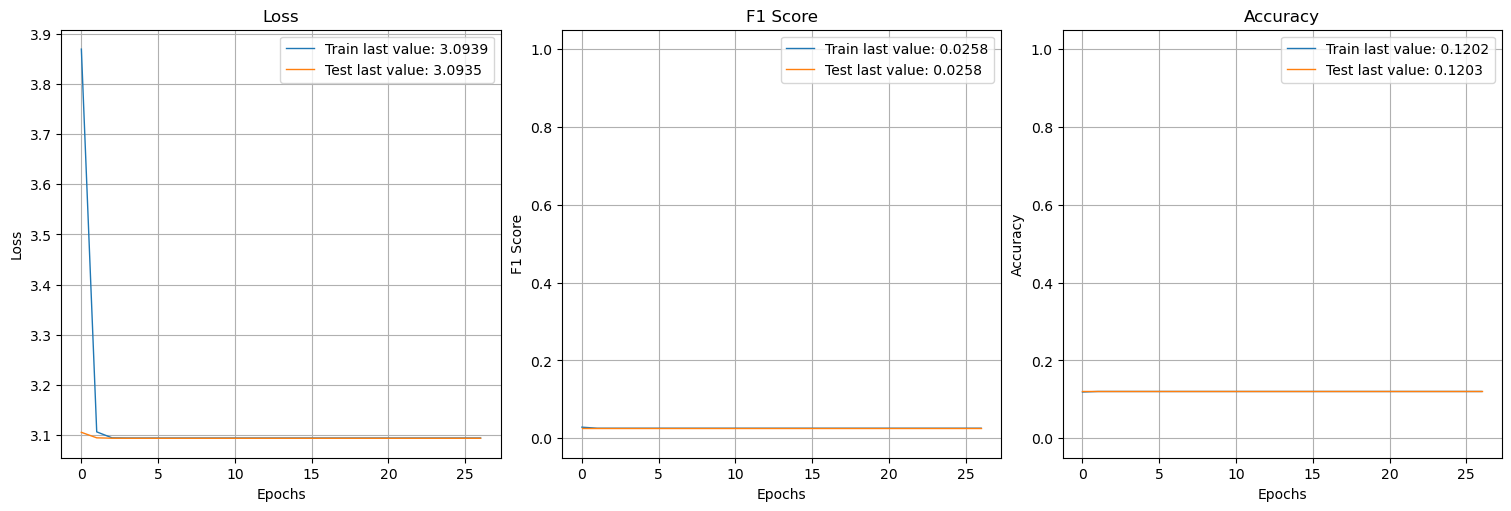

In [59]:
show_history(basic_cnn_history)
plot_history(basic_cnn_history, path="standard.png")
plt.close()

In [60]:
basic_cnn.load_weights(basic_cnn_save_path)

y_pred = np.array([])
y_true = np.array([])
for x, y in val_set:
    y_pred = np.concatenate([y_pred, np.argmax(basic_cnn.predict(x), axis = -1)])
    y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

cm = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
cm_normalized_horizontally = cm / cm.sum(axis=1)
cm_normalized_vertically = cm / cm.sum(axis=0)

2024-05-24 17:53:50.941117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 113ms/step


2024-05-24 17:54:06.509953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/var/folders/n1/c5p933t10874315ft89zcr800000gn/T/ipykernel_1583/1161568971.py:11: RuntimeWarning: invalid value encountered in divide
  cm_normalized_vertically = cm / cm.sum(axis=0)


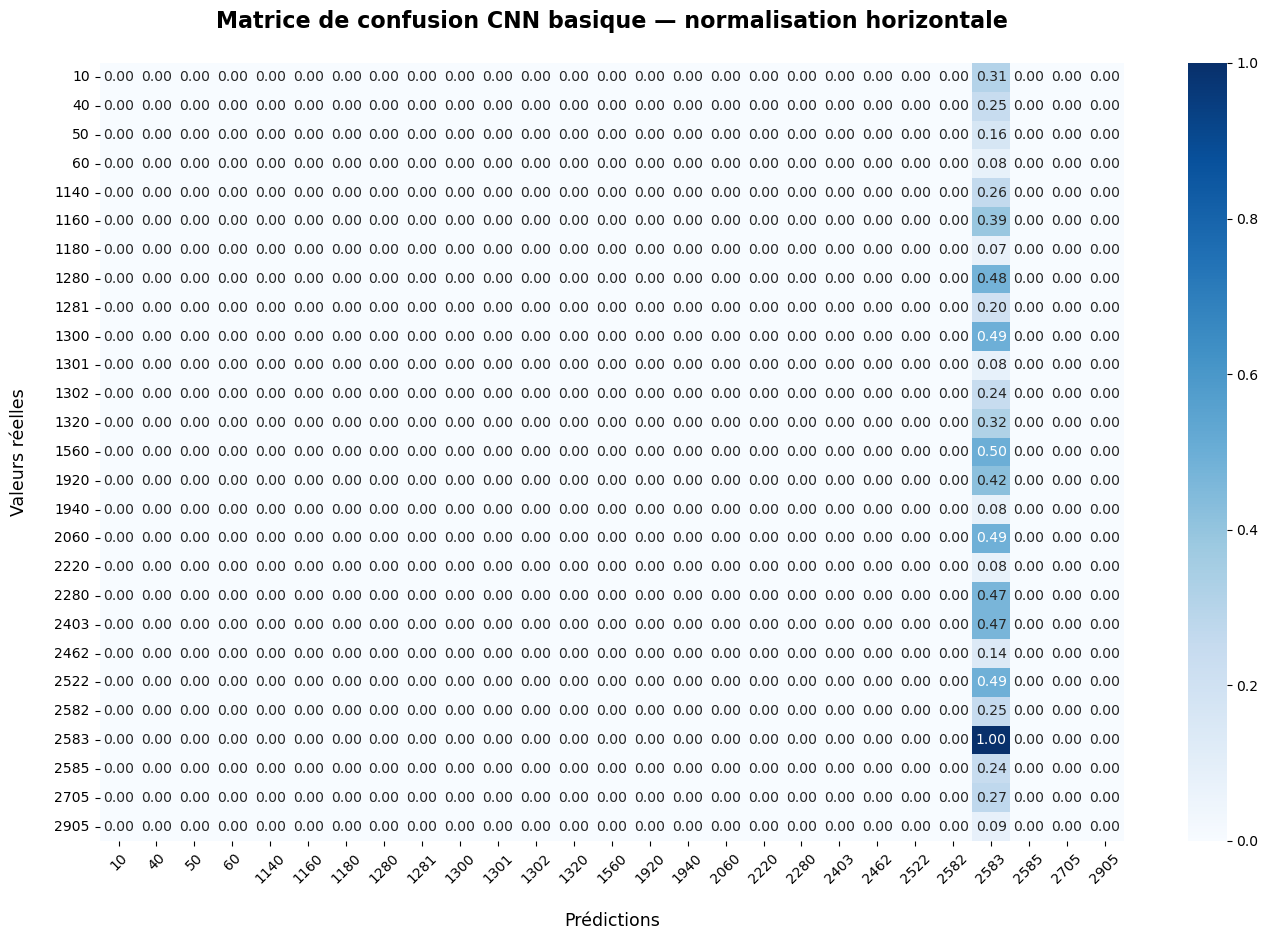

In [61]:
# Confusion matrix with horizontal normalization
plt.figure(figsize=(14, 9.5))
sns.heatmap(data=cm_normalized_horizontally, vmin=0, vmax=1, annot=True, cmap="Blues", fmt='.2f', 
            xticklabels=labels, yticklabels=labels)
plt.title('Matrice de confusion CNN basique — normalisation horizontale\n', fontsize=16, fontweight='bold')
plt.xlabel('\nPrédictions', fontsize=12.5)
plt.ylabel('Valeurs réelles\n', fontsize=12.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

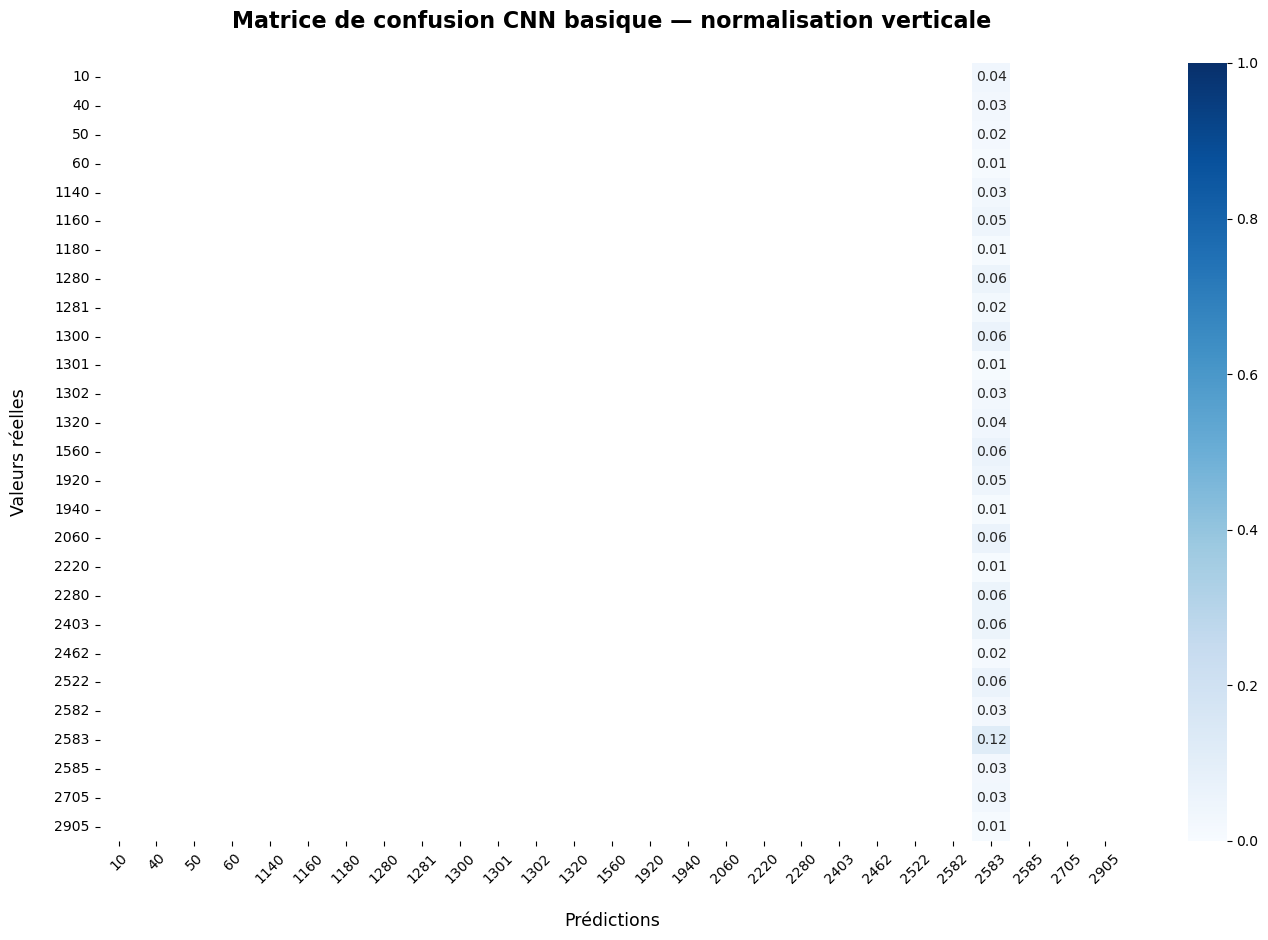

In [62]:
# Confusion matrix with vertical normalization
plt.figure(figsize=(14, 9.5))
sns.heatmap(data=cm_normalized_vertically, vmin=0, vmax=1, annot=True, cmap="Blues", fmt='.2f', 
            xticklabels=labels, yticklabels=labels)
plt.title('Matrice de confusion CNN basique — normalisation verticale\n', fontsize=16, fontweight='bold')
plt.xlabel('\nPrédictions', fontsize=12.5)
plt.ylabel('Valeurs réelles\n', fontsize=12.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [63]:
report = classification_report(np.array(y_true), np.array(y_pred), target_names=labels)
print(report)

              precision    recall  f1-score   support

          10       0.00      0.00      0.00       499
          40       0.00      0.00      0.00       401
          50       0.00      0.00      0.00       269
          60       0.00      0.00      0.00       133
        1140       0.00      0.00      0.00       427
        1160       0.00      0.00      0.00       632
        1180       0.00      0.00      0.00       122
        1280       0.00      0.00      0.00       779
        1281       0.00      0.00      0.00       331
        1300       0.00      0.00      0.00       807
        1301       0.00      0.00      0.00       129
        1302       0.00      0.00      0.00       399
        1320       0.00      0.00      0.00       519
        1560       0.00      0.00      0.00       812
        1920       0.00      0.00      0.00       689
        1940       0.00      0.00      0.00       128
        2060       0.00      0.00      0.00       799
        2220       0.00    

/Users/antoine/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/antoine/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/antoine/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

### ResNet50

In [9]:
# Create model
resnet50 = create_model(base_model=ResNet50)

# Create callback
ResNet50_save_path = "ResNet50_best_weights.keras"
checkpoint = ModelCheckpoint(ResNet50_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks_list = [checkpoint, es]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [10]:
%%time
resnet50_history = fit_model_and_get_history(resnet50)

Epoch 1/100


2024-05-23 20:50:42.379709: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-05-23 20:50:42.381272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1699/1699 [==============================] - ETA: 0s - loss: 2.0510 - f1_score: 0.3766 - accuracy: 0.4042

2024-05-23 20:52:46.397106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.72061, saving model to ResNet50_best_weights_2.keras
1699/1699 [==============================] - 156s 91ms/step - loss: 2.0510 - f1_score: 0.3766 - accuracy: 0.4042 - val_loss: 1.7206 - val_f1_score: 0.4539 - val_accuracy: 0.4902
Epoch 2/100
1698/1699 [============================>.] - ETA: 0s - loss: 1.7789 - f1_score: 0.4530 - accuracy: 0.4739
Epoch 2: val_loss improved from 1.72061 to 1.64678, saving model to ResNet50_best_weights_2.keras
1699/1699 [==============================] - 151s 89ms/step - loss: 1.7787 - f1_score: 0.4531 - accuracy: 0.4740 - val_loss: 1.6468 - val_f1_score: 0.4848 - val_accuracy: 0.5103
Epoch 3/100
1698/1699 [============================>.] - ETA: 0s - loss: 1.6826 - f1_score: 0.4798 - accuracy: 0.4975
Epoch 3: val_loss improved from 1.64678 to 1.60046, saving model to ResNet50_best_weights_2.keras
1699/1699 [==============================] - 152s 89ms/step - loss: 1.6828 - f1_score: 0.4797 - accuracy: 0.4975 - va

In [11]:
get_optimal_epoch_scores(model=resnet50, model_backup_path=ResNet50_save_path)

1699/1699 [==============================] - 122s 72ms/step - loss: 1.1410 - f1_score: 0.6324 - accuracy: 0.6416
Training f1-score   : 0.6324
Training Accuracy   : 0.6416

Validation f1-score   : 0.5431
Validation Accuracy :  0.5545


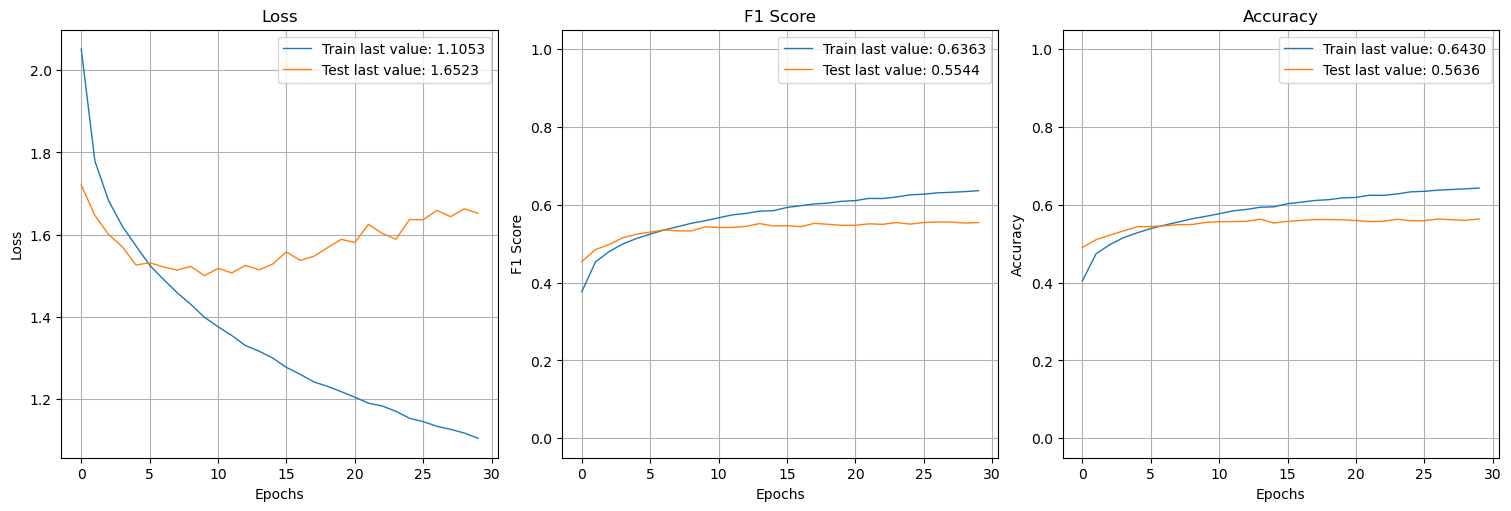

In [12]:
show_history(resnet50_history)
plot_history(resnet50_history, path="standard.png")
plt.close()

In [14]:
resnet50.load_weights(ResNet50_save_path)

y_pred = np.array([])
y_true = np.array([])
for x, y in val_set:
    y_pred = np.concatenate([y_pred, np.argmax(resnet50.predict(x), axis = -1)])
    y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

cm = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
cm_normalized_horizontally = cm / cm.sum(axis=1)
cm_normalized_vertically = cm / cm.sum(axis=0)

2024-05-23 22:14:58.707419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 22ms/step


2024-05-23 22:15:37.132511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 925ms/step


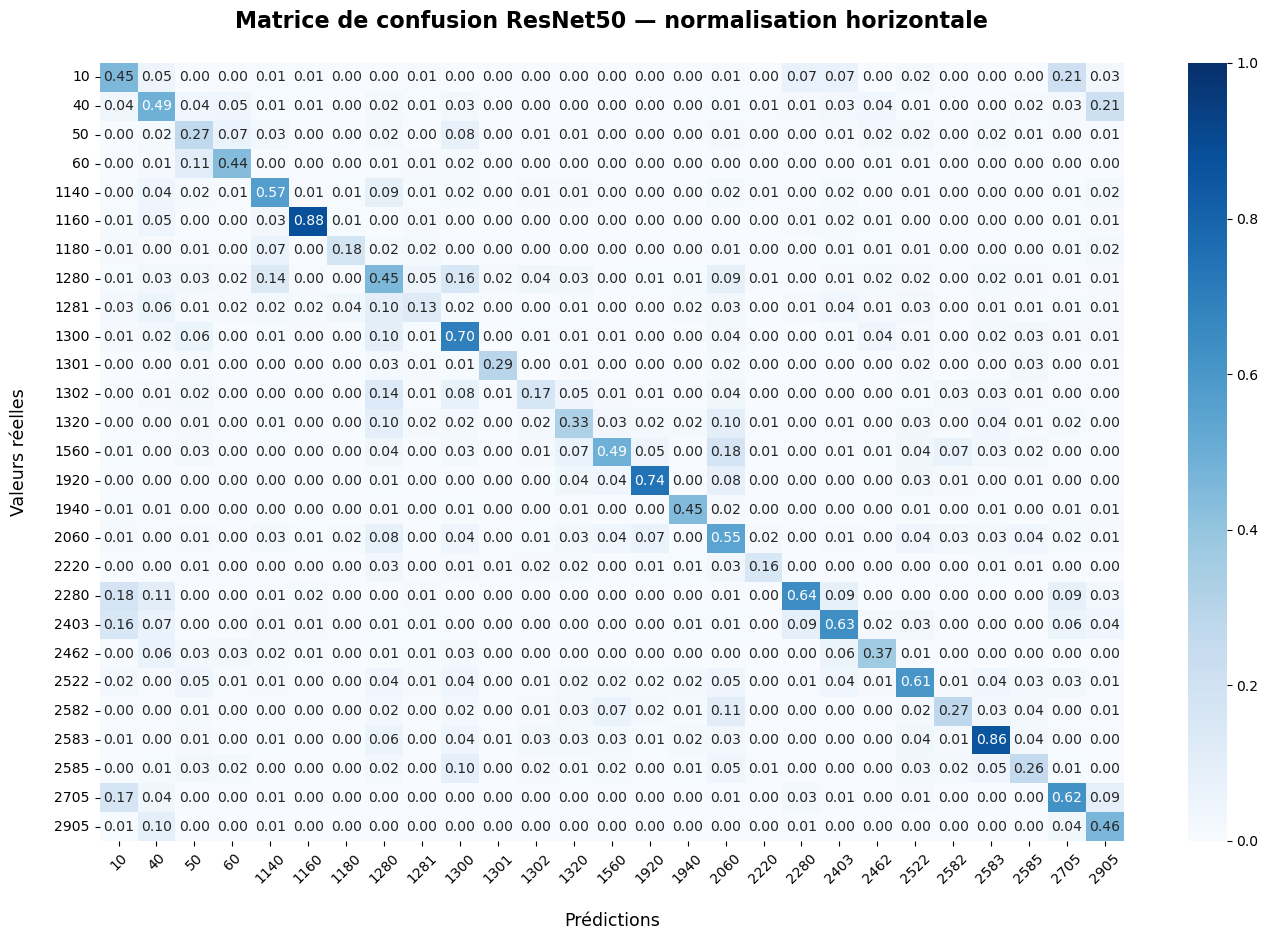

In [22]:
# Confusion matrix with horizontal normalization
plt.figure(figsize=(14, 9.5))
sns.heatmap(data=cm_normalized_horizontally, vmin=0, vmax=1, annot=True, cmap="Blues", fmt='.2f', 
            xticklabels=labels, yticklabels=labels)
plt.title('Matrice de confusion ResNet50 — normalisation horizontale\n', fontsize=16, fontweight='bold')
plt.xlabel('\nPrédictions', fontsize=12.5)
plt.ylabel('Valeurs réelles\n', fontsize=12.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

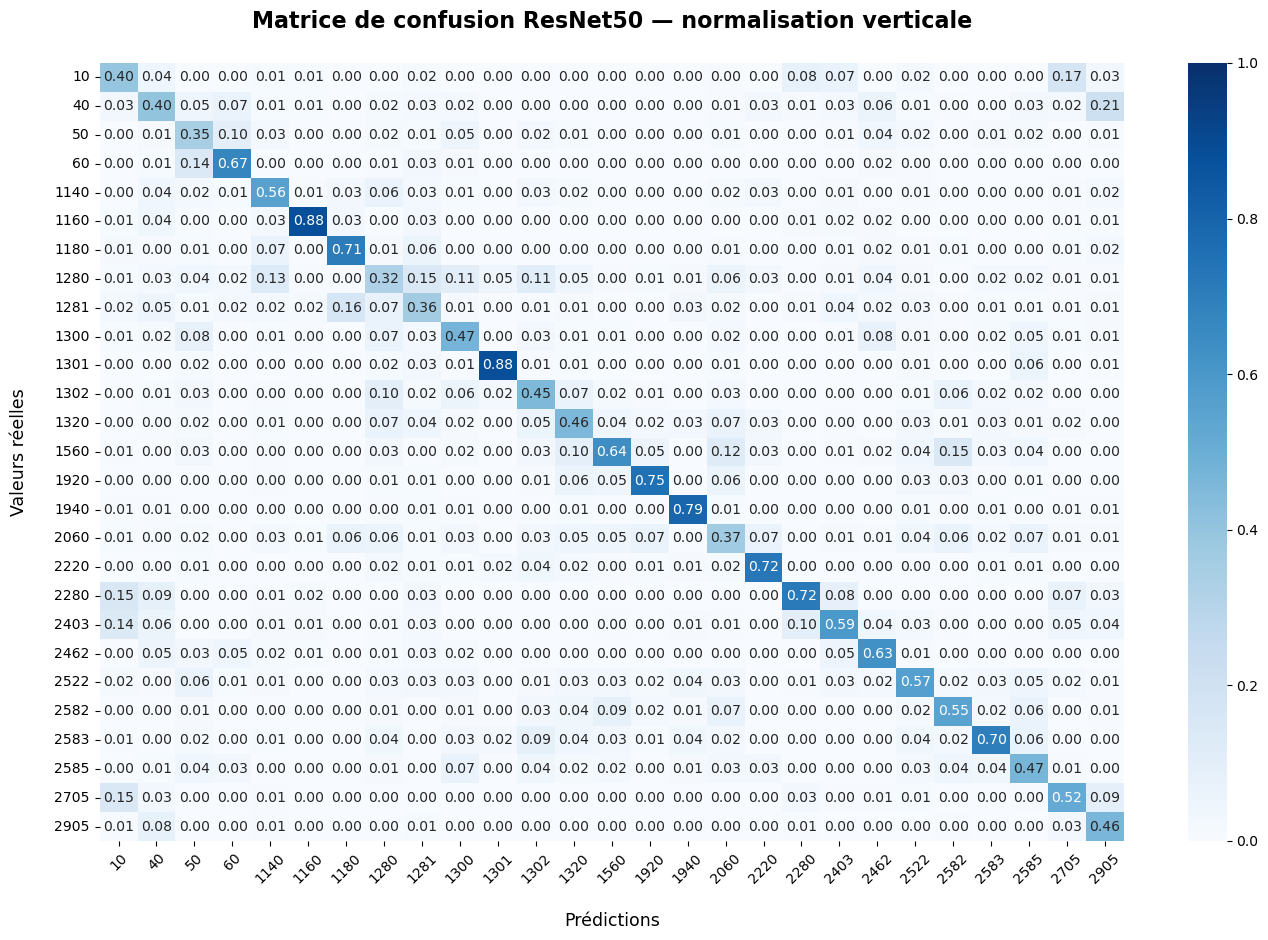

In [21]:
# Confusion matrix with vertical normalization
plt.figure(figsize=(14, 9.5))
sns.heatmap(data=cm_normalized_vertically, vmin=0, vmax=1, annot=True, cmap="Blues", fmt='.2f', 
            xticklabels=labels, yticklabels=labels)
plt.title('Matrice de confusion ResNet50 — normalisation verticale\n', fontsize=16, fontweight='bold')
plt.xlabel('\nPrédictions', fontsize=12.5)
plt.ylabel('Valeurs réelles\n', fontsize=12.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
report = classification_report(np.array(y_true), np.array(y_pred), target_names=labels)
print(report)

              precision    recall  f1-score   support

          10       0.40      0.45      0.42       499
          40       0.40      0.49      0.44       401
          50       0.35      0.27      0.30       269
          60       0.67      0.44      0.53       133
        1140       0.56      0.57      0.57       427
        1160       0.88      0.88      0.88       632
        1180       0.71      0.18      0.29       122
        1280       0.32      0.45      0.38       779
        1281       0.36      0.13      0.19       331
        1300       0.47      0.70      0.57       807
        1301       0.88      0.29      0.44       129
        1302       0.45      0.17      0.24       399
        1320       0.46      0.33      0.38       519
        1560       0.64      0.49      0.55       812
        1920       0.75      0.74      0.75       689
        1940       0.79      0.45      0.57       128
        2060       0.37      0.55      0.44       799
        2220       0.72    

### VGG16

In [44]:
# Create model
vgg16 = create_model(base_model=VGG16)

# Create callback
vgg16_save_path = "VGG16_best_weights.keras"
checkpoint = ModelCheckpoint(vgg16_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks_list = [checkpoint, es]

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [45]:
%%time
vgg16_history = fit_model_and_get_history(vgg16)

Epoch 1/100


2024-05-24 01:14:01.793224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1699/1699 [==============================] - ETA: 0s - loss: 2.4829 - f1_score: 0.3126 - accuracy: 0.3433

2024-05-24 01:17:28.939175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.84518, saving model to VGG16_best_weights.keras
1699/1699 [==============================] - 259s 152ms/step - loss: 2.4829 - f1_score: 0.3126 - accuracy: 0.3433 - val_loss: 1.8452 - val_f1_score: 0.4150 - val_accuracy: 0.4509
Epoch 2/100
1699/1699 [==============================] - ETA: 0s - loss: 1.9498 - f1_score: 0.4001 - accuracy: 0.4278
Epoch 2: val_loss improved from 1.84518 to 1.73674, saving model to VGG16_best_weights.keras
1699/1699 [==============================] - 255s 150ms/step - loss: 1.9498 - f1_score: 0.4001 - accuracy: 0.4278 - val_loss: 1.7367 - val_f1_score: 0.4483 - val_accuracy: 0.4791
Epoch 3/100
1699/1699 [==============================] - ETA: 0s - loss: 1.8463 - f1_score: 0.4301 - accuracy: 0.4552
Epoch 3: val_loss improved from 1.73674 to 1.69239, saving model to VGG16_best_weights.keras
1699/1699 [==============================] - 258s 152ms/step - loss: 1.8463 - f1_score: 0.4301 - accuracy: 0.4552 - val_loss: 1.69

In [46]:
get_optimal_epoch_scores(model=vgg16, model_backup_path=vgg16_save_path)

1699/1699 [==============================] - 204s 120ms/step - loss: 1.3466 - f1_score: 0.5720 - accuracy: 0.5888
Training f1-score   : 0.5720
Training Accuracy   : 0.5888

Validation f1-score   : 0.5084
Validation Accuracy :  0.5272


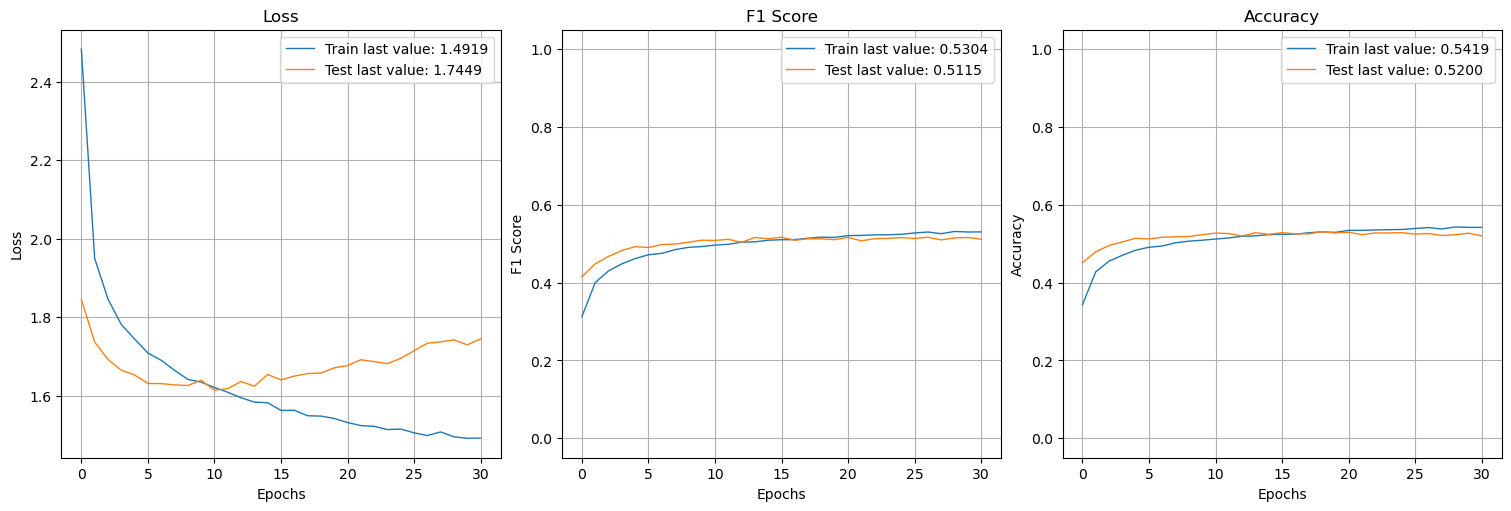

In [47]:
show_history(vgg16_history)
plot_history(vgg16_history, path="standard.png")
plt.close()

In [48]:
vgg16.load_weights(vgg16_save_path)

y_pred = np.array([])
y_true = np.array([])
for x, y in val_set:
    y_pred = np.concatenate([y_pred, np.argmax(vgg16.predict(x), axis = -1)])
    y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

cm = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
cm_normalized_horizontally = cm / cm.sum(axis=1)
cm_normalized_vertically = cm / cm.sum(axis=0)

2024-05-24 03:30:04.057952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 14ms/step


2024-05-24 03:31:02.737560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 525ms/step


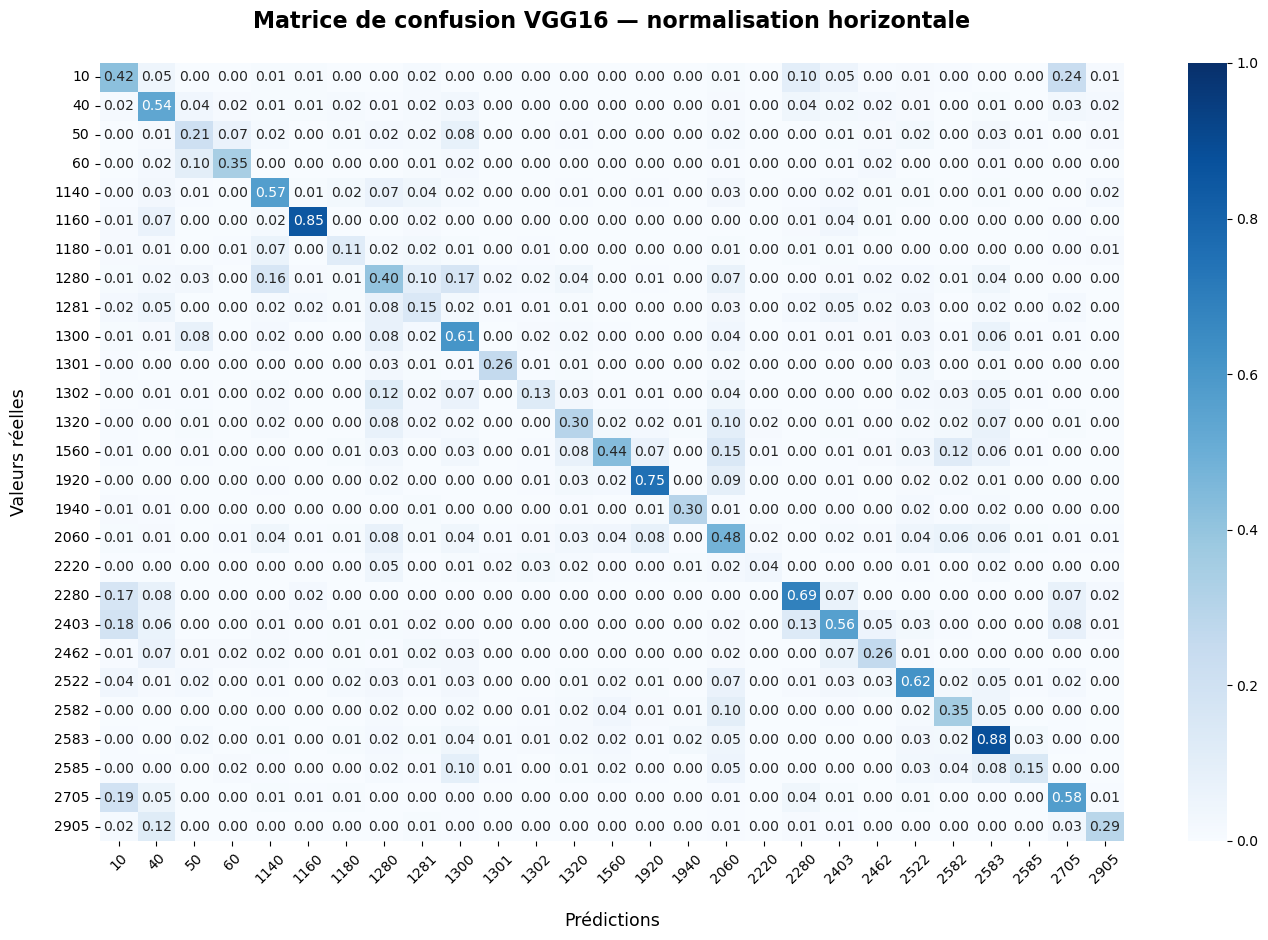

In [49]:
# Confusion matrix with horizontal normalization
plt.figure(figsize=(14, 9.5))
sns.heatmap(data=cm_normalized_horizontally, vmin=0, vmax=1, annot=True, cmap="Blues", fmt='.2f', 
            xticklabels=labels, yticklabels=labels)
plt.title('Matrice de confusion VGG16 — normalisation horizontale\n', fontsize=16, fontweight='bold')
plt.xlabel('\nPrédictions', fontsize=12.5)
plt.ylabel('Valeurs réelles\n', fontsize=12.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

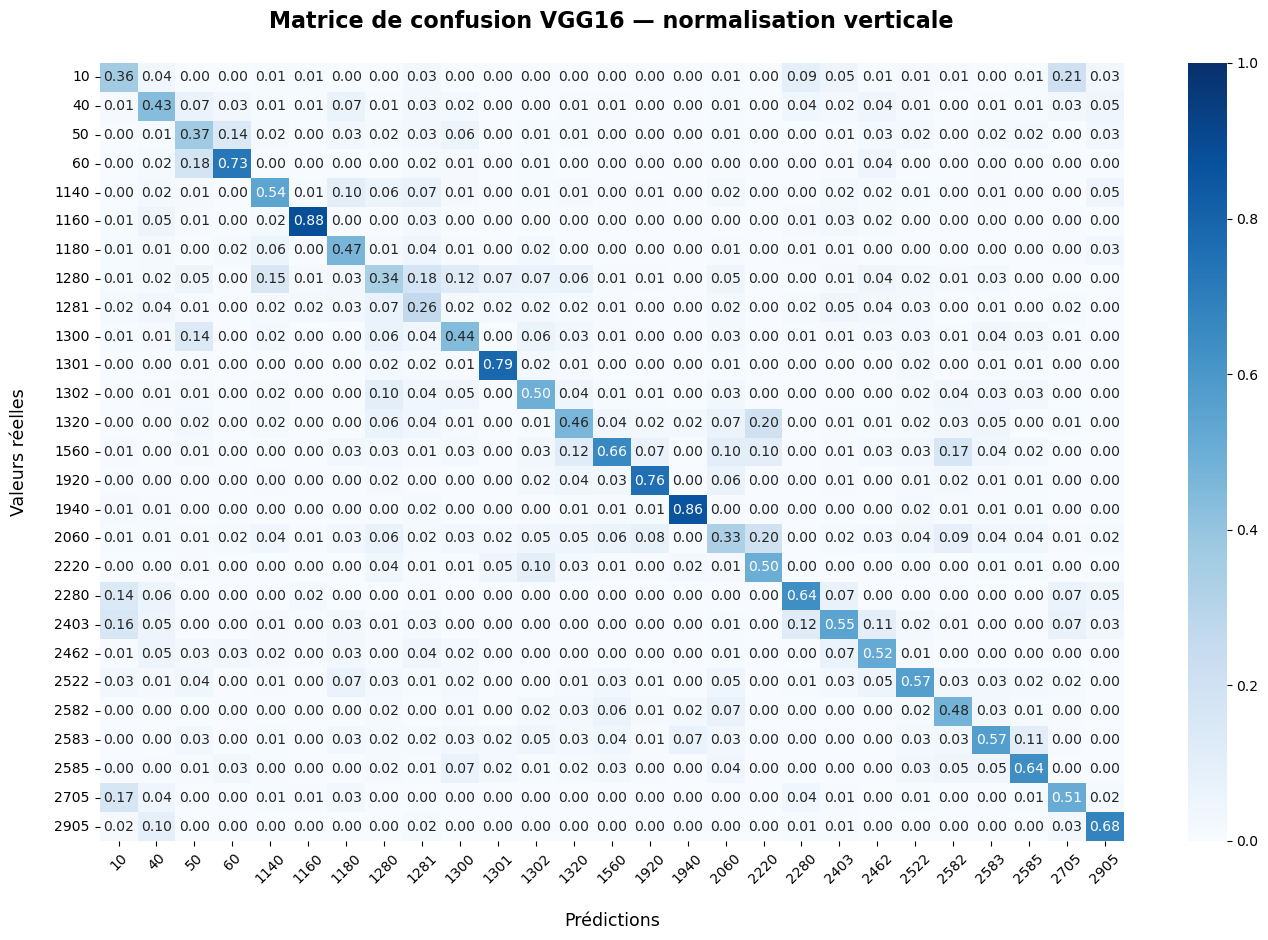

In [50]:
# Confusion matrix with vertical normalization
plt.figure(figsize=(14, 9.5))
sns.heatmap(data=cm_normalized_vertically, vmin=0, vmax=1, annot=True, cmap="Blues", fmt='.2f', 
            xticklabels=labels, yticklabels=labels)
plt.title('Matrice de confusion VGG16 — normalisation verticale\n', fontsize=16, fontweight='bold')
plt.xlabel('\nPrédictions', fontsize=12.5)
plt.ylabel('Valeurs réelles\n', fontsize=12.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [51]:
report = classification_report(np.array(y_true), np.array(y_pred), target_names=labels)
print(report)

              precision    recall  f1-score   support

          10       0.36      0.42      0.39       499
          40       0.43      0.54      0.48       401
          50       0.37      0.21      0.27       269
          60       0.73      0.35      0.47       133
        1140       0.54      0.57      0.56       427
        1160       0.88      0.85      0.86       632
        1180       0.47      0.11      0.18       122
        1280       0.34      0.40      0.37       779
        1281       0.26      0.15      0.19       331
        1300       0.44      0.61      0.51       807
        1301       0.79      0.26      0.39       129
        1302       0.50      0.13      0.20       399
        1320       0.46      0.30      0.36       519
        1560       0.66      0.44      0.53       812
        1920       0.76      0.75      0.76       689
        1940       0.86      0.30      0.44       128
        2060       0.33      0.48      0.39       799
        2220       0.50    

### EfficientNetV2M

In [36]:
# Create model
efficientnetV2M = create_model(base_model=EfficientNetV2M)

# Create callback
EfficientNetV2M_save_path = "EfficientNetV2M_best_weights.keras"
checkpoint = ModelCheckpoint(EfficientNetV2M_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks_list = [checkpoint, es]

214201816/214201816 [==============================] - 6s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                         

In [37]:
%%time
efficientnetV2M_history = fit_model_and_get_history(efficientnetV2M)

Epoch 1/100


2024-05-23 22:57:49.273269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1699/1699 [==============================] - ETA: 0s - loss: 1.7746 - f1_score: 0.4653 - accuracy: 0.4822

2024-05-23 23:01:59.803920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.46080, saving model to EfficientNetV2M_best_weights.keras
1699/1699 [==============================] - 322s 182ms/step - loss: 1.7746 - f1_score: 0.4653 - accuracy: 0.4822 - val_loss: 1.4608 - val_f1_score: 0.5399 - val_accuracy: 0.5563
Epoch 2/100
1699/1699 [==============================] - ETA: 0s - loss: 1.5320 - f1_score: 0.5283 - accuracy: 0.5399
Epoch 2: val_loss improved from 1.46080 to 1.41214, saving model to EfficientNetV2M_best_weights.keras
1699/1699 [==============================] - 290s 171ms/step - loss: 1.5320 - f1_score: 0.5283 - accuracy: 0.5399 - val_loss: 1.4121 - val_f1_score: 0.5632 - val_accuracy: 0.5706
Epoch 3/100
1699/1699 [==============================] - ETA: 0s - loss: 1.4500 - f1_score: 0.5546 - accuracy: 0.5649
Epoch 3: val_loss improved from 1.41214 to 1.38040, saving model to EfficientNetV2M_best_weights.keras
1699/1699 [==============================] - 290s 171ms/step - loss: 1.4500 - f1_score: 0.5546 - acc

In [38]:
get_optimal_epoch_scores(model=efficientnetV2M, model_backup_path=EfficientNetV2M_save_path)

1699/1699 [==============================] - 229s 135ms/step - loss: 0.9531 - f1_score: 0.6996 - accuracy: 0.7032
Training f1-score   : 0.6996
Training Accuracy   : 0.7032

Validation f1-score   : 0.5833
Validation Accuracy :  0.5891


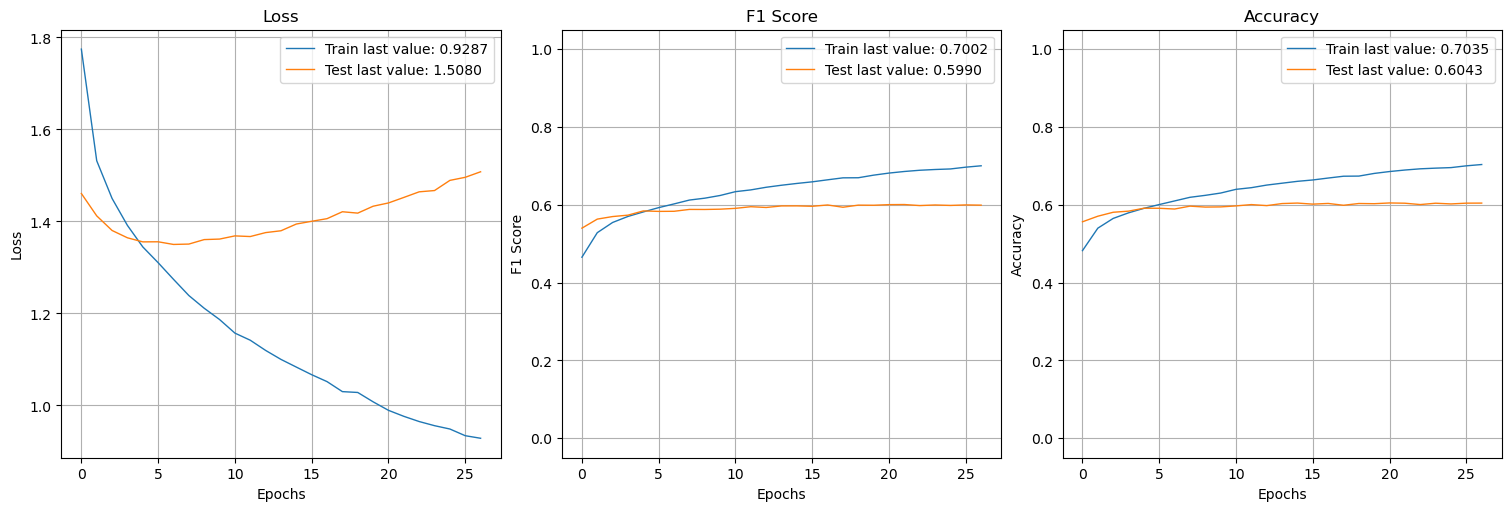

In [39]:
show_history(efficientnetV2M_history)
plot_history(efficientnetV2M_history, path="standard.png")
plt.close()

In [40]:
efficientnetV2M.load_weights(EfficientNetV2M_save_path)

y_pred = np.array([])
y_true = np.array([])
for x, y in val_set:
    y_pred = np.concatenate([y_pred, np.argmax(efficientnetV2M.predict(x), axis = -1)])
    y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

cm = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
cm_normalized_horizontally = cm / cm.sum(axis=1)
cm_normalized_vertically = cm / cm.sum(axis=0)

2024-05-24 01:12:40.953689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 95ms/step


2024-05-24 01:13:51.892015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 9s 9s/step


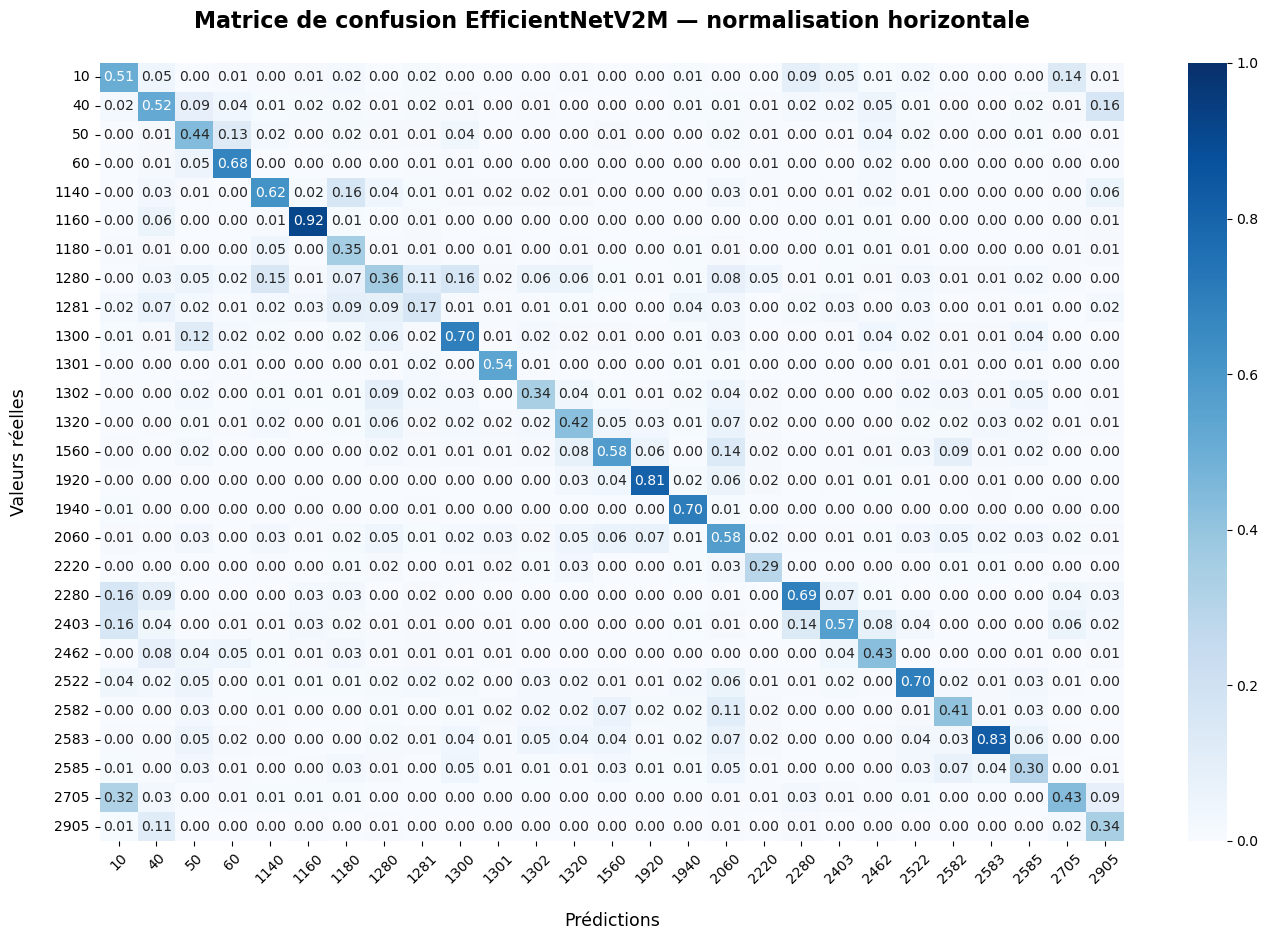

In [41]:
# Confusion matrix with horizontal normalization
plt.figure(figsize=(14, 9.5))
sns.heatmap(data=cm_normalized_horizontally, vmin=0, vmax=1, annot=True, cmap="Blues", fmt='.2f', 
            xticklabels=labels, yticklabels=labels)
plt.title('Matrice de confusion EfficientNetV2M — normalisation horizontale\n', fontsize=16, fontweight='bold')
plt.xlabel('\nPrédictions', fontsize=12.5)
plt.ylabel('Valeurs réelles\n', fontsize=12.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

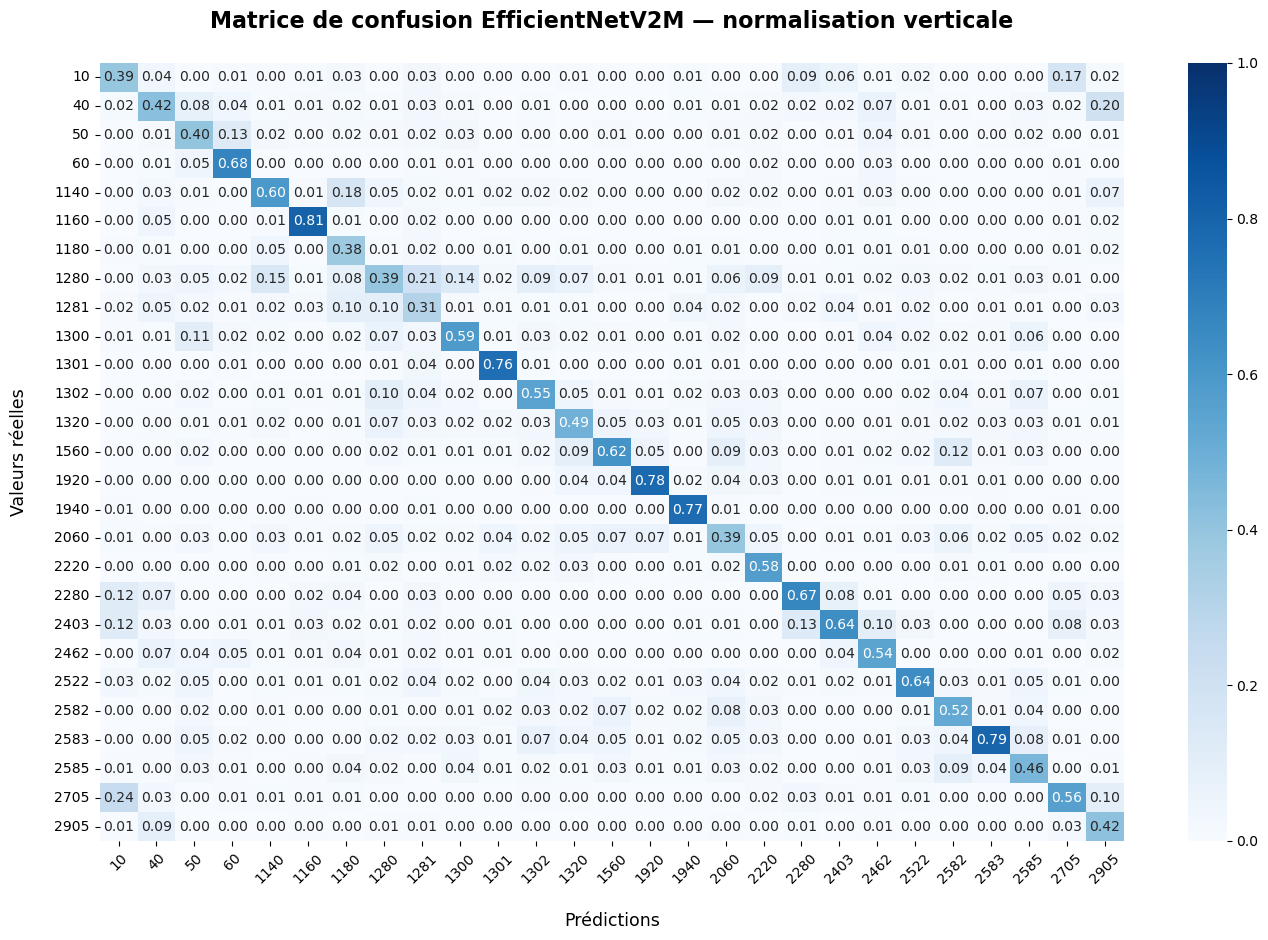

In [42]:
# Confusion matrix with vertical normalization
plt.figure(figsize=(14, 9.5))
sns.heatmap(data=cm_normalized_vertically, vmin=0, vmax=1, annot=True, cmap="Blues", fmt='.2f', 
            xticklabels=labels, yticklabels=labels)
plt.title('Matrice de confusion EfficientNetV2M — normalisation verticale\n', fontsize=16, fontweight='bold')
plt.xlabel('\nPrédictions', fontsize=12.5)
plt.ylabel('Valeurs réelles\n', fontsize=12.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
report = classification_report(np.array(y_true), np.array(y_pred), target_names=labels)
print(report)

              precision    recall  f1-score   support

          10       0.39      0.51      0.44       499
          40       0.42      0.52      0.47       401
          50       0.40      0.44      0.42       269
          60       0.68      0.68      0.68       133
        1140       0.60      0.62      0.61       427
        1160       0.81      0.92      0.86       632
        1180       0.38      0.35      0.36       122
        1280       0.39      0.36      0.38       779
        1281       0.31      0.17      0.22       331
        1300       0.59      0.70      0.64       807
        1301       0.76      0.54      0.63       129
        1302       0.55      0.34      0.42       399
        1320       0.49      0.42      0.45       519
        1560       0.62      0.58      0.60       812
        1920       0.78      0.81      0.79       689
        1940       0.77      0.70      0.73       128
        2060       0.39      0.58      0.47       799
        2220       0.58    

## Avec tuning